# Proyek Klasifikasi Gambar: Animals Image Classification Dataset
- **Nama:** Reisya Junita Putri
- **Email:** reisyajunita@gmail.com
- **ID Dicoding:** reisyajunita

**Dataset Summary**

The Animal Image Classification Dataset is a comprehensive collection of images tailored for the development and evaluation of machine learning models in the field of computer vision. It contains 3,000 JPG images, carefully segmented into three classes representing common pets and wildlife: cats, dogs, and snakes.

**Dataset Contents**
* cats/: A set of 1,000 JPG images of cats, showcasing a wide array of breeds, environments, and postures.

* dogs/: A diverse compilation of 1,000 dog images, capturing a multitude of breeds in various activities and settings.

* snakes/: An assortment of 1,000 images of snakes, depicting numerous species in both natural and controlled habitats. Image Details:

* Resolution: Each image maintains a uniform resolution of 256x256 pixels, providing clarity and consistency for model training.

* File Format: JPG Color Space: RGB

**Source**

https://huggingface.co/datasets/AlvaroVasquezAI/Animal_Image_Classification_Dataset

#### Install Module

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Import Semua Packages/Library yang Digunakan

In [ ]:
# --- Libraries yang digunakan ---
import os
import pathlib
import random
import shutil
import zipfile

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from google.colab import files, drive

# --- Mengimpor libraries untuk visualisasi ---
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# --- Mengimpor libraries untuk pemrosesan data gambar ---
from PIL import Image

# --- Mengimpor libraries untuk pembuatan dan evaluasi model ---
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# --- Mengabaikan peringatan ---
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- TensorFlow Version ---
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


## Data Preparation

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Data Loading

In [ ]:
# Path ke folder dataset
dataset_path = '/content/drive/MyDrive/proyek_klasifikasi_gambar/'
zip_file_name = 'animals_image.zip'
zip_file_path = f'{dataset_path}{zip_file_name}'

# Direktori tujuan untuk mengestrak isi zip
extraction_path = dataset_path
!unzip '{zip_file_path}' -d '{extraction_path}'

print(f"File '{zip_file_name}' berhasil diekstrak ke: {extraction_path}")

# Menghapus file zip setelah berhasil diekstrak
try:
  os.remove(zip_file_path)
  print(f"File '{zip_file_name} berhasil dihapus dari {dataset_path}")
except FileNotFoundError:
  print(f"File '{zip_file_name}' tidak ditemukan di: {dataset_path}")
except Exception as e:
  print(f"Terjadi kesalahan saat menghapus file: {e}")

print(f"Isi dari '{zip_file_name}' berhasil diekstrak ke: {extraction_path}")

Archive:  /content/drive/MyDrive/proyek_klasifikasi_gambar/animals_image.zip
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0001.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0002.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0003.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0004.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0005.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0006.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0007.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0008.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0009.jpg  
  inflating: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/cats/0_0010.jpg  
  inflating: /content/drive/MyDrive/proyek_

### Plot Gambar Sample untuk Semua Kelas

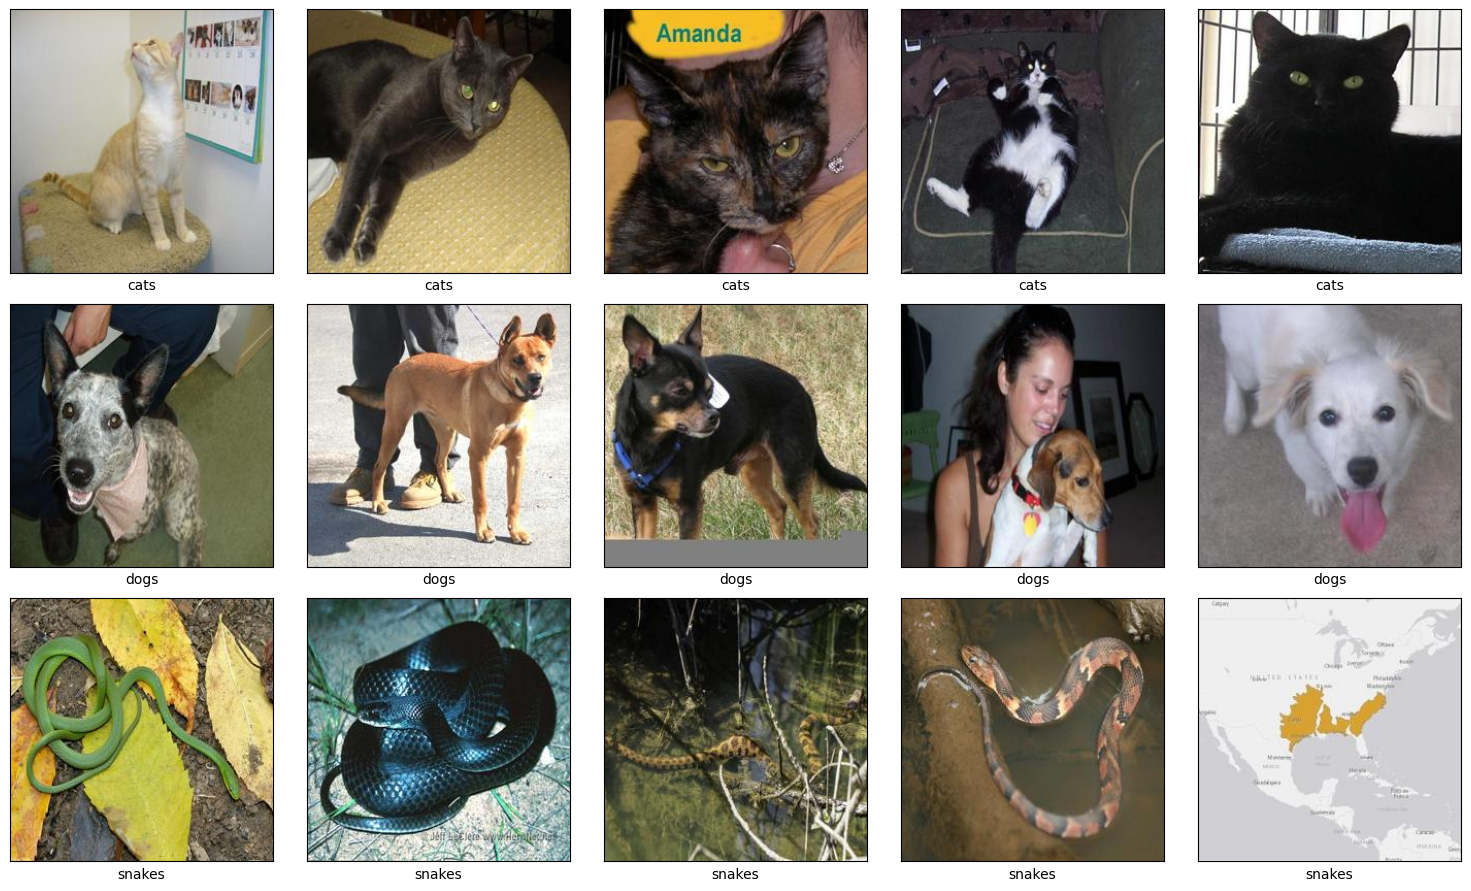

In [ ]:
# Path ke direktori utama yang berisi folder-folder jenis hewan
dataset_dir = '/content/drive/MyDrive/proyek_klasifikasi_gambar/Animals/'
num_samples = 5  # Jumlah gambar yang ingin ditampilkan per kelas

# Membuat kamus yang menyimpan daftar gambar untuk setiap jenis garbage
animals_image = {category: os.listdir(os.path.join(dataset_dir, category))
             for category in os.listdir(dataset_dir)
             if os.path.isdir(os.path.join(dataset_dir, category))}

# Membuat figure dan axes untuk menampilkan gambar
fig, axs = plt.subplots(len(animals_image.keys()), num_samples, figsize=(15, 3 * len(animals_image.keys())))

# Loop melalui setiap jenis garbage (kelas)
for i, class_name in enumerate(animals_image.keys()):
    # Memilih 5 gambar acak dari daftar gambar untuk kelas saat ini
    images = np.random.choice(animals_image[class_name], min(num_samples, len(animals_image[class_name])), replace=False)

    # Loop melalui 5 gambar yang dipilih
    for j, image_name in enumerate(images):
        # Membuat path lengkap ke file gambar
        img_path = os.path.join(dataset_dir, class_name, image_name)
        try:
            # Membuka gambar dan mengonversinya
            img = Image.open(img_path).convert("RGB")  # Atau "L" untuk grayscale
            # Menampilkan gambar pada subplot yang sesuai
            axs[i, j].imshow(img)
            # Mengatur label (nama kelas), menghilangkan ticks
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        except Exception as e:
            print(f"Gagal membuka gambar: {img_path} - {e}")
            axs[i, j].set_title("Error")

# Menyesuaikan layout agar tidak ada tumpang tindih
fig.tight_layout()
# Menampilkan plot
plt.show()

### Plot Distribusi Gambar di Seluruh Kelas

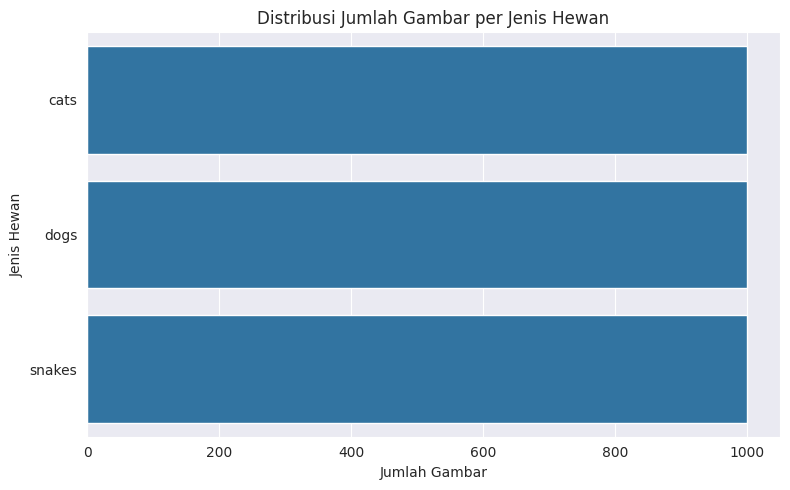


Jumlah Gambar per Kelas:
labels
cats      1000
dogs      1000
snakes    1000
Name: count, dtype: int64


In [ ]:
# Membuat list untuk menyimpan nama file, path lengkap, dan label
file_name = []
labels = []
full_path = []

# Mengumpulkan nama file, path lengkap, dan label dari setiap gambar
for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Membuat DataFrame dari data yang terkumpul
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Menghitung jumlah gambar per kelas
label_counts = distribution_train['labels'].value_counts().sort_values(ascending=False)

# Plot distribusi untuk semua kelas
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution_train, order=label_counts.index)
plt.title('Distribusi Jumlah Gambar per Jenis Hewan')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Jenis Hewan')
plt.tight_layout()
plt.show()

print("\nJumlah Gambar per Kelas:")
print(label_counts)

### Data Preprocessing

#### Split Dataset

In [ ]:
# Path ke folder dataset utama
mypath = '/content/drive/MyDrive/proyek_klasifikasi_gambar/Animals'
animals_final_dir = '/content/drive/MyDrive/proyek_klasifikasi_gambar/Animals_final'
train_dir = os.path.join(animals_final_dir, 'train')
val_dir = os.path.join(animals_final_dir, 'val')
test_dir = os.path.join(animals_final_dir, 'test')

In [ ]:
# --- Membuat Direktori Animals_final, train, val, test (Jika diperlukan) ---
os.makedirs(animals_final_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# --- Mengumpulkan Daftar File dan Label ---
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Membuat DataFrame
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})
print('\n===================================================== ')
print("Jumlah gambar per label sebelum splitting:")
print(df.groupby(['labels']).size())
print('===================================================== \n')


Jumlah gambar per label sebelum splitting:
labels
cats      1000
dogs      1000
snakes    1000
dtype: int64



In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300, stratify=y)

#### temp md

In [ ]:
# Membuat subdirektori untuk setiap kelas di dalam direktori train, test, dan val
for label in df['labels'].unique():
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# Menyalin file ke direktori train dan test yang sesuai
for index, row in tq(pd.DataFrame({'path': X_train, 'labels': y_train}).iterrows(), desc='Memindahkan data training'):
    src = row['path']
    dst = os.path.join(train_dir, row['labels'], os.path.basename(src))
    shutil.copy2(src, dst)

for index, row in tq(pd.DataFrame({'path': X_test, 'labels': y_test}).iterrows(), desc='Memindahkan data testing'):
    src = row['path']
    dst = os.path.join(test_dir, row['labels'], os.path.basename(src))
    shutil.copy2(src, dst)

# Membuat validation set (10% dari data awal, diambil dari data training sebelum dipindahkan)
X_train_temp, X_val, y_train_temp, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=300, stratify=y_train)

for index, row in tq(pd.DataFrame({'path': X_val, 'labels': y_val}).iterrows(), desc='Memindahkan data validasi'):
    src = row['path']
    dst = os.path.join(val_dir, row['labels'], os.path.basename(src))
    shutil.copy2(src, dst)

print("\nProses splitting dan penyalinan data selesai.")
print(f"Data training berada di: {train_dir}")
print(f"Data testing berada di: {test_dir}")
print(f"Data validasi berada di: {val_dir}")

Memindahkan data training: 0it [00:00, ?it/s]

Memindahkan data testing: 0it [00:00, ?it/s]

Memindahkan data validasi: 0it [00:00, ?it/s]


Proses splitting dan penyalinan data selesai.
Data training berada di: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals_final/train
Data testing berada di: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals_final/test
Data validasi berada di: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals_final/val


#### Image Data Generator

In [ ]:
# --- Parameter Model ---
img_height, img_width = 160, 160
batch_size = 32
epochs = 100

# --- Image Data Generator dengan target size yang sesuai ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2400 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## Modelling

### Transfer Learning dengan MobileNet

In [ ]:
# --- Membangun Model Sequential dengan Transfer Learning ---
pretrained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in pretrained_model.layers:
    layer.trainable = False

model_sequential = models.Sequential([
    pretrained_model,
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Kompilasi model
model_sequential.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_sequential.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_160 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 128)      │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,474,691 (17.07 MB)

 Trainable params: 1,245,827 (4.75 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# --- Pelatihan Model ---
history = model_sequential.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 562s 7s/step - accuracy: 0.7093 - loss: 1.5979 - val_accuracy: 0.9821 - val_loss: 0.0490 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9429 - loss: 0.1678 - val_accuracy: 0.9821 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9615 - loss: 0.1129 - val_accuracy: 0.9777 - val_loss: 0.0502 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9611 - loss: 0.1166 - val_accuracy: 0.9955 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9713 - loss: 0.0807 - val_accuracy: 0.9866 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9768 - loss: 0.0719 - val_accuracy: 0.9911 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9592 - loss: 0.1030 - v

## Evaluasi dan Visualisasi

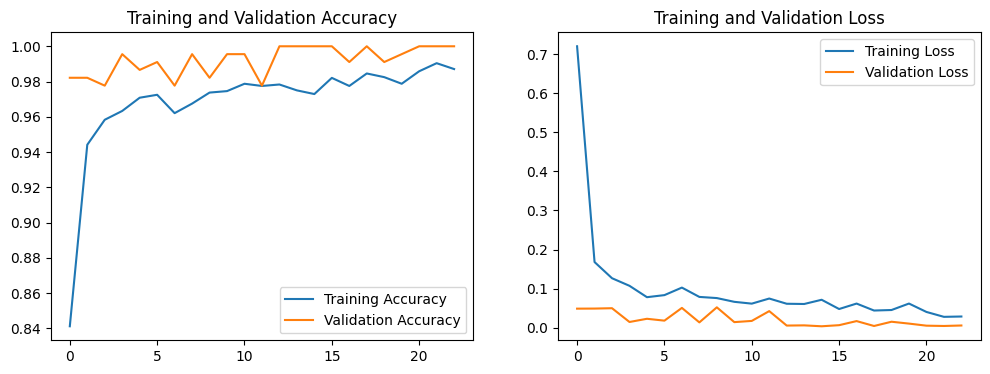

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# --- Evaluasi Model ---
eval_result = model_sequential.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Loss pada data testing:", eval_result[0])
print("Akurasi pada data testing:", eval_result[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - accuracy: 0.9689 - loss: 0.2042
Loss pada data testing: 0.12145405262708664
Akurasi pada data testing: 0.9756944179534912


## Konversi Model

In [ ]:
# --- Menyimpan Model dalam Format SavedModel ---
saved_model_path = os.path.join(animals_final_dir, 'saved_model')
model_sequential.export(saved_model_path)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_path}")

Saved artifact at '/content/drive/MyDrive/proyek_klasifikasi_gambar/Animals_final/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_86')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137904212185296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212185680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212183184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212185872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212187408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212183568: Tensor

In [ ]:
# --- Konversi model Keras ke format TF-Lite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model_sequential)
tflite_model = converter.convert()

# Tentukan path untuk menyimpan model TF-Lite
tflite_model_path = os.path.join(animals_final_dir, 'tf_lite', 'model.tflite')
os.makedirs(os.path.dirname(tflite_model_path), exist_ok=True)

# Simpan model TF-Lite ke file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model (Sequential) berhasil disimpan dalam format TF-Lite di: {tflite_model_path}")

Saved artifact at '/tmp/tmpqdvlti_t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_86')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137904212185296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212185680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212183184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212186064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212185872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212187408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137904212183568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13790421218

In [ ]:
# --- Membuat Label File untuk TF Lite ---
label_file_path = os.path.join(animals_final_dir, 'tf_lite', 'label.txt')
class_names = sorted(train_generator.class_indices.keys())
with open(label_file_path, 'w') as f:
    f.write('\n'.join(class_names))
print(f"File label.txt berhasil dibuat di: {label_file_path}")

File label.txt berhasil dibuat di: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals_final/tf_lite/label.txt


In [ ]:
# --- Konversi ke TFJS ---
tfjs_model_path = os.path.join(animals_final_dir, 'tfjs_model')
tfjs.converters.save_keras_model(model_sequential, tfjs_model_path)
print(f"Model (Sequential) berhasil disimpan dalam format TFJS di: {tfjs_model_path}")

failed to lookup keras version from the file,
    this is likely a weight only file
Model (Sequential) berhasil disimpan dalam format TFJS di: /content/drive/MyDrive/proyek_klasifikasi_gambar/Animals_final/tfjs_model


## Inference (Optional)

In [ ]:
# --- Inferensi dengan TF Lite ---
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

img_path = os.path.join(test_dir, class_names[1], os.listdir(os.path.join(test_dir, class_names[1]))[0]) # Ambil contoh gambar dari kelas kedua
img = Image.open(img_path).resize((img_height, img_width))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class_index = np.argmax(output_data[0])
predicted_class_name = class_names[predicted_class_index]
confidence = output_data[0][predicted_class_index]

print("\nHasil Prediksi (TF Lite - Sequential):")
print(f"Kelas yang diprediksi: {predicted_class_name}")
print(f"Tingkat kepercayaan: {confidence:.4f}")


Hasil Prediksi (TF Lite - Sequential):
Kelas yang diprediksi: dogs
Tingkat kepercayaan: 1.0000
